✅ 한글 폰트 설정 완료
[LightGBM] [Info] Number of positive: 27716, number of negative: 86134
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points in the train set: 113850, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.243443 -> initscore=-1.133894
[LightGBM] [Info] Start training from score -1.133894
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.967045

🏆 모델 성능 결과
✅ 정확도 (Accuracy): 0.8606
✅ F1 점수 (F1 Score): 0.7703

[상세 리포트]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     21534
           1       0.64      0.96      0.77      6929

    accuracy                           0.86     2

C:\Users\qkrwl\AppData\Local\Temp\ipykernel_2852\2701390138.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Feature", data=feature_imp, palette="viridis")


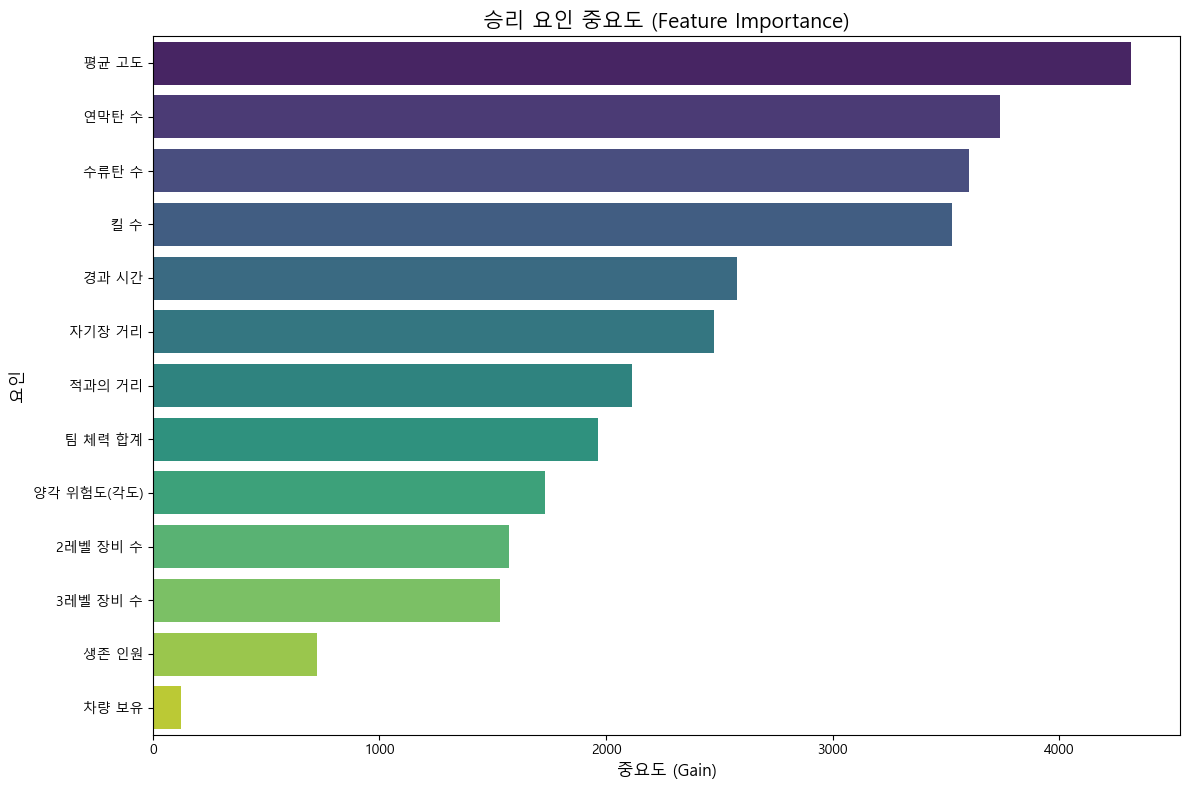

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report # f1_score 추가

# ==========================================
# [0] 한글 폰트 설정 (깨짐 방지)
# ==========================================
import matplotlib.font_manager as fm
import os

def set_korean_font():
    # 운영체제별 기본 한글 폰트 설정
    if os.name == 'nt': # Windows
        plt.rc('font', family='Malgun Gothic')
    elif os.name == 'posix': # Mac/Linux
        plt.rc('font', family='AppleGothic')
    
    # 마이너스 기호 깨짐 방지
    plt.rc('axes', unicode_minus=False)
    print("✅ 한글 폰트 설정 완료")

set_korean_font()

# ==========================================
# [1] 데이터 로드
# ==========================================
file_path = 'data_1.csv' # 이전에 생성한 데이터셋 파일

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("❌ 데이터 파일을 찾을 수 없습니다.")
    exit()

# ==========================================
# [2] 모델 학습 (LightGBM)
# ==========================================
features = [
    'time_sec', 'num_alive', 'total_health',
    'num_lv3_gear', 'num_lv2_gear', 
    'num_smokes', 'num_grenades',
    'kills', 'has_vehicle',
    'dist_to_safezone', 'dist_to_nearest_enemy', 
    'max_enemy_angle', 'avg_height'
]

X = df[features]
y = df['is_winner']

# 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBM 분류기
lgbm = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    objective='binary',
    metric='auc', # 학습 과정에선 AUC를 보지만
    scale_pos_weight=5, # 데이터 불균형 완화
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# ==========================================
# [3] 결과 확인 (F1 Score 포함)
# ==========================================
y_pred = lgbm.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) # F1 점수 계산

print("\n" + "="*30)
print(f"🏆 모델 성능 결과")
print(f"✅ 정확도 (Accuracy): {acc:.4f}")
print(f"✅ F1 점수 (F1 Score): {f1:.4f}") # 사용자가 원한 정보
print("="*30)

print("\n[상세 리포트]")
print(classification_report(y_test, y_pred))

# ==========================================
# [4] 중요 변수 시각화 (한글 라벨 적용)
# ==========================================
# 변수명을 한글로 매핑 (그래프용)
kor_feature_names = {
    'time_sec': '경과 시간',
    'num_alive': '생존 인원',
    'total_health': '팀 체력 합계',
    'num_lv3_gear': '3레벨 장비 수',
    'num_lv2_gear': '2레벨 장비 수',
    'num_smokes': '연막탄 수',
    'num_grenades': '수류탄 수',
    'kills': '킬 수',
    'has_vehicle': '차량 보유',
    'dist_to_safezone': '자기장 거리',
    'dist_to_nearest_enemy': '적과의 거리',
    'max_enemy_angle': '양각 위험도(각도)',
    'avg_height': '평균 고도'
}

# 중요도 데이터프레임 생성
feature_imp = pd.DataFrame({
    'Value': lgbm.feature_importances_,
    'Feature': [kor_feature_names.get(f, f) for f in features] # 한글 이름으로 변환
}).sort_values(by="Value", ascending=False)

# 그래프 그리기
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp, palette="viridis")
plt.title('승리 요인 중요도 (Feature Importance)', fontsize=15)
plt.xlabel('중요도 (Gain)', fontsize=12)
plt.ylabel('요인', fontsize=12)
plt.tight_layout()
plt.show()